# ACM PROJECT: Sign Language Recognition

## Main Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns
print("Files successfully input")

Files successfully input


## Parquet and CSV linkage

In [2]:
trainmain = pd.read_csv("/kaggle/input/asl-signs/train.csv")
trainmain.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
trainmain.shape

(94477, 4)

Given files are in train_landmark_files subfolder and in parquet format. We have been given a train.csv file that contains the location of each parquet file that is associated with output. We need to link the two data sources to begin EDA. Let's start by building a simple function that takes in parquet data at given location!

In [4]:
def get_pq_data(path):
    '''
    Essentially a wrapper function that simplifies our workload
    '''
    return pd.read_parquet("/kaggle/input/asl-signs/"+path,engine = 'auto')

In [5]:
# Testing above function to see if it works
t_data = get_pq_data('train_landmark_files/16069/100015657.parquet')
t_data.head()

,frame,row_id,type,landmark_index,x,y,z
0,103,103-face-0,face,0,0.437886,0.437599,-0.051134
1,103,103-face-1,face,1,0.443258,0.392901,-0.067054
2,103,103-face-2,face,2,0.443997,0.409998,-0.042990
3,103,103-face-3,face,3,0.435256,0.362771,-0.039492
4,103,103-face-4,face,4,0.443780,0.381762,-0.068013


In [6]:
# Our function works let's use it to get one row from train.csv
t_data = get_pq_data(trainmain['path'][1])
t_data.head()

,frame,row_id,type,landmark_index,x,y,z
0,29,29-face-0,face,0,0.577776,0.509360,-0.050245
1,29,29-face-1,face,1,0.572079,0.470164,-0.075696
2,29,29-face-2,face,2,0.572135,0.483382,-0.044619
3,29,29-face-3,face,3,0.561517,0.437963,-0.050466
4,29,29-face-4,face,4,0.572215,0.459153,-0.078405


In [7]:
t_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5973 entries, 0 to 5972
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           5973 non-null   int16  
 1   row_id          5973 non-null   object 
 2   type            5973 non-null   object 
 3   landmark_index  5973 non-null   int16  
 4   x               5553 non-null   float64
 5   y               5553 non-null   float64
 6   z               5553 non-null   float64
dtypes: float64(3), int16(2), object(2)
memory usage: 256.8+ KB


In [8]:
t_data['type'].unique()

array(['face', 'left_hand', 'pose', 'right_hand'], dtype=object)

2.2179934978485107


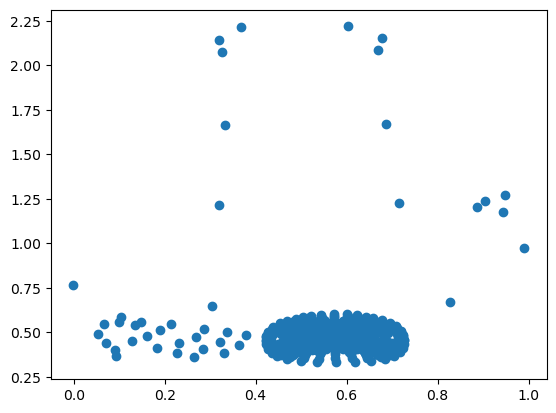

In [9]:
# Taking inspiration from another project let's try to create an image out of landmark data
def draw_landmarks_basic(ldmrkdat):
    # This is a very basic version that doesn't consider the structuring of human arms
    plt.scatter(ldmrkdat['x'],ldmrkdat['y'])
    print(ldmrkdat['y'].max())
    plt.show()
draw_landmarks_basic(t_data.loc[ t_data['frame'] == 29 ])

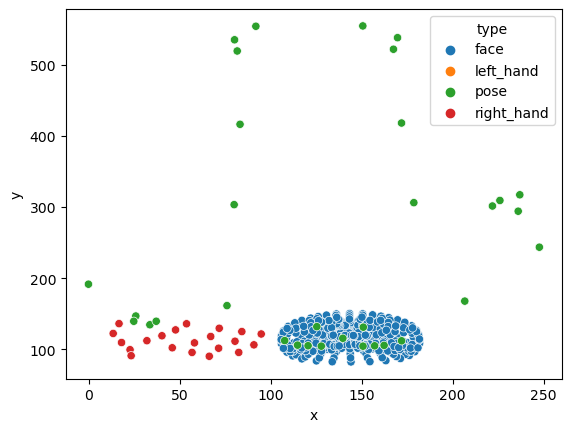

In [10]:
# The Above graph doesn't give us much information about understanding what we have here
# let's try colouring the landmarks on the type
def draw_landmarks_basicv2(ldkm):
    sns.scatterplot(x= ldkm['x']*250,y= ldkm['y']*250, hue=ldkm['type'])
    plt.show()
draw_landmarks_basicv2(t_data.loc[ t_data['frame'] == 29 ])   

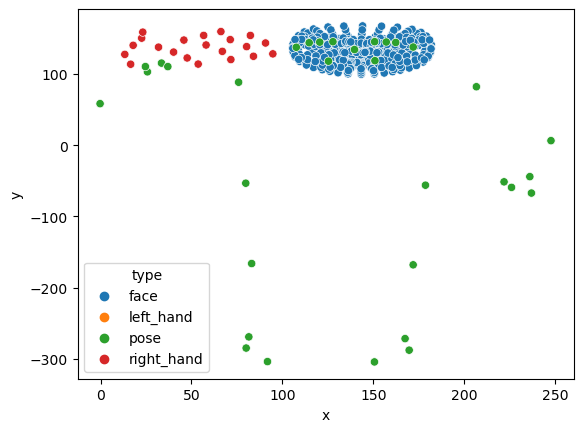

In [11]:
# Turns out the picture is upside down...took our researchers at google millions of years to figure out lmao
def draw_landmarks_basicv2(ldkm):
    sns.scatterplot(x= ldkm['x']*250,y= (1-ldkm['y'])*250, hue=ldkm['type'])
    plt.show()
draw_landmarks_basicv2(t_data.loc[ t_data['frame'] == 29 ])   

Much better understanding of features can be found here

# EDA

**Components of Media Pipe Output** [LINK](https://developers.google.com/mediapipe/solutions/vision/holistic_landmarker)
- Face (468 markers)
- Pose (33 markers)
- Hands (21 markers/hand)
---
We need to determine the most important markers out of these for our task, since we have nearly 543 landmarks! Let us perform a bit of EDA for the same.

In [12]:
# Since we have a huge dataset (Sizes are too big for us to load the entire frame data)... Let's sample 100 'videos' out of the entire set
study_samples = trainmain.iloc[:100]
print("Population size:",trainmain.shape)
print("Sample size:",study_samples.shape)

Population size: (94477, 4)
Sample size: (100, 4)


In [13]:
study_samples.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


**To Perfom complete eda we need to augment the parquet files into the data frame**

In [14]:
def aug_parquet(path,pid,seqid):
    '''
    Input:-
    - Path:- file path of parquet data
    - pid:- participant_id
    - seqid:- sequence_id
    Output:-
    - Returns augdf which is a augmented dataframe which has pid and seqid columns(which we will use to join the dataframes)
    '''
    augdf = get_pq_data(path)
    augdf['participant_id'] = pid
    augdf['sequence_id'] = seqid
    return augdf

In [15]:
# Let's test our function on a small part of our data
test = study_samples.iloc[0]
testaug = aug_parquet(test['path'],test['participant_id'],test['sequence_id'])
testaug.shape

(12489, 9)

In [16]:
# The last part works! Let's work on augmenting the rest 99 into one augdf!
augdf = testaug
for i in range(1,100):
    iterval = study_samples.iloc[i]
    iteraug = aug_parquet(iterval['path'],iterval['participant_id'],iterval['sequence_id'])
    augdf = augdf.append(iteraug,ignore_index = True)
augdf.tail(15)

,frame,row_id,type,landmark_index,x,y,z,participant_id,sequence_id
1724010,26,26-right_hand-6,right_hand,6,0.297091,0.444173,-0.058431,18796,1004199462
1724011,26,26-right_hand-7,right_hand,7,0.321697,0.414231,-0.073246,18796,1004199462
1724012,26,26-right_hand-8,right_hand,8,0.337601,0.389799,-0.084633,18796,1004199462
1724013,26,26-right_hand-9,right_hand,9,0.215545,0.478143,-0.043354,18796,1004199462
1724014,26,26-right_hand-10,right_hand,10,0.282095,0.418577,-0.064975,18796,1004199462
1724015,26,26-right_hand-11,right_hand,11,0.311889,0.378092,-0.078721,18796,1004199462
1724016,26,26-right_hand-12,right_hand,12,0.336066,0.345581,-0.089109,18796,1004199462
1724017,26,26-right_hand-13,right_hand,13,0.173744,0.476918,-0.054420,18796,1004199462
1724018,26,26-right_hand-14,right_hand,14,0.206942,0.409067,-0.084310,18796,1004199462
1724019,26,26-right_hand-15,right_hand,15,0.216088,0.362591,-0.109404,18796,1004199462


In [17]:
# We have all the data we need to do EDA on this sample...Just one join away! (Cross fingers n hope aws doesn't assassinate me!)
eda_sample = pd.merge(study_samples , augdf,on = ['participant_id','sequence_id'],how ='inner')
eda_sample.head()

,path,participant_id,sequence_id,sign,frame,row_id,type,landmark_index,x,y,z
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,20,20-face-4,face,4,0.495304,0.341821,-0.061152


In [18]:
def create_input(df,i,j):
    '''
    Input:-
    - df:- dataframe
    - i:- starting point of data
    - j:- ending point of data
    Output:-
    - Returns augdf which is a augmented dataframe which has pid and seqid columns(which we will use to join the dataframes)
    '''
    aug = aug_parquet(df['path'],df['participant_id'],df['sequence_id'])
    for i in range(i,j):
        iterval = study_samples.iloc[i]
        iteraug = aug_parquet(iterval['path'],iterval['participant_id'],iterval['sequence_id'])
        augdf = augdf.append(iteraug,ignore_index = True)
    eda_sample = pd.merge(df , augdf,on = ['participant_id','sequence_id'],how ='inner')

In [19]:
#sign frequency distribution
dict(eda_sample['sign'].value_counts())

{'cloud': 179190,
 'TV': 111315,
 'mitten': 76563,
 'clown': 68961,
 'alligator': 67875,
 'owl': 62445,
 'brother': 41811,
 'closet': 40725,
 'flower': 39639,
 'old': 36924,
 'scissors': 36381,
 'shoe': 34209,
 'moon': 33666,
 'drawer': 32580,
 'uncle': 32580,
 'finish': 32037,
 'lips': 30951,
 'orange': 28779,
 'find': 27150,
 'bad': 26064,
 'duck': 26064,
 'same': 23892,
 'store': 23892,
 'there': 23349,
 'yellow': 22263,
 'can': 22263,
 'dry': 21177,
 'wake': 20634,
 'backyard': 19548,
 'vacuum': 17919,
 'first': 17919,
 'time': 17376,
 'hungry': 17376,
 'shirt': 16290,
 'blow': 15747,
 'fish': 15204,
 'balloon': 14661,
 'milk': 14661,
 'quiet': 14118,
 'sick': 13032,
 'go': 13032,
 'minemy': 12489,
 'shhh': 12489,
 'pizza': 12489,
 'giraffe': 12489,
 'cowboy': 11403,
 'say': 10860,
 'puzzle': 10317,
 'bee': 10317,
 'owie': 9774,
 'not': 9774,
 'open': 9774,
 'wet': 9231,
 'cheek': 9231,
 'black': 8145,
 'sun': 8145,
 'jacket': 7602,
 'look': 7602,
 'grass': 7602,
 'now': 7602,
 'ap

In [20]:
# Checking distribution of parameters over the 